### Brian Shula, 2024
This project creates a Physics Informed Neural Network to approximate the time-varying temperature distribution in a fin as it cools due to convection and radiation from an initial temperature.  The neural network is trained with sparse data from a finite element model (ground truth), and employs the governing partial differential equations to calculate Loss from model residuals.  A schematic of the problem is shown below:

![Fin Setup](Fin_Setup.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(47)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

In [3]:
#Whether to scale inputs and outputs to neural network
scale = True

In [4]:
#FEA Data - Ground Truth coordinates, time, and temperature
df_data = pd.read_csv('Nodal_Temperatures.csv')
df_data.head()

,Node,x,y,time,temperature
0,1,0.0,0.0,0.0,250.0
1,1,0.0,0.0,10.0,250.0
2,1,0.0,0.0,20.0,250.0
3,1,0.0,0.0,30.0,250.0
4,1,0.0,0.0,50.0,250.0


In [5]:
model_data = np.array(df_data[['x','y','time','temperature']])

In [6]:
#Random shuffle - shuffle data pairs for splitting
np.random.seed(23)

rng = np.random.default_rng()
rng.shuffle(model_data)

In [7]:
model_data.shape

(102663, 4)

In [8]:
#Training data set - subset of total FEA data
ndata = model_data.shape[0]//10

#Test/Train Split
xyt_train = model_data[:ndata, 0:3]
xyt_test = model_data[ndata:, 0:3]

T_train = model_data[:ndata, 3]
T_test = model_data[ndata:, 3]

#Scale
xyt_train_scaler = MinMaxScaler()
xyt_train = xyt_train_scaler.fit_transform(xyt_train)
xyt_test = xyt_train_scaler.transform(xyt_test)

#Reshape and Scale
T_train = T_train.reshape((-1,1))
T_test = T_test.reshape((-1,1))


#Define scaler but don't fit - Loss calculated in physical domain
T_train_scaler = MinMaxScaler()
T_train_scaler.fit(T_train)
    
#Temperature Scaler quantities: Tscaled = (T - Tmin) / Trange
Trange = T_train_scaler.data_range_[0]
Tmin = T_train_scaler.data_min_[0]

In [9]:
#Convert Inputs, Outputs to Torch tensors
xyt_train_pt = torch.tensor(xyt_train, dtype=torch.float32).to(device)
xyt_test_pt = torch.tensor(xyt_test, dtype=torch.float32).to(device)

T_train_pt = torch.tensor(T_train, dtype=torch.float32).to(device)
T_test_pt = torch.tensor(T_test, dtype=torch.float32).to(device)

In [10]:
#Heat Transfer Constants
k = 186 #Thermal conductivity, W/m*K
cp = 875 #Specific Heat, J/kg*K
rho = 2770 #Density, kg/m^3

SB = 5.67e-8 #Stefan-Boltzmann constant W/m^2*K^4
eps = 0.8 #Emissivity
film_coeff = 50 #Conection film coefficient, W/m^2*K

T_inf = 25 #Degrees C, surrounding temperature
T_init = 250 #Degrees C
T_bc = 250 #Degrees C

#Model information
xmin = 0 #meters
ymin = 0 #meters

xmax = 0.05 #meters
ymax = 0.25 #meters

tmin = 0 #seconds
tmax = 3600 #seconds

In [11]:
#Collocation Discretization
#Place points inside block
xybuffer = .002
tbuffer = 10

ncoll_pts = 20

xdims = np.linspace(xmin + xybuffer, xmax - xybuffer, ncoll_pts)
ydims = np.linspace(ymin + xybuffer, ymax - xybuffer, 3 * ncoll_pts)
tsteps = np.linspace(tmin + tbuffer, tmax - tbuffer, 6 * ncoll_pts)

xx, yy, tt = np.meshgrid(xdims, ydims, tsteps)

xx = xx.reshape((-1,1))
yy = yy.reshape((-1,1))
tt = tt.reshape((-1,1))

In [12]:
#Group and convert to PyTorch variable
xyt_coll = np.concatenate((xx, yy, tt), axis=1)

#Shuffle
rng.shuffle(xyt_coll)

#Scale
xyt_coll = xyt_train_scaler.transform(xyt_coll)

#Convert to PyTorch tensor
xyt_coll_pt = torch.tensor(xyt_coll, dtype=torch.float32, requires_grad=True).to(device)

# PINN Model Setup

## Physics Loss Function

In [13]:
def physics_loss(pts, net):
    
    #Calculate loss of d**2T/dx**2 + d**2T/dy**2 = dT/dt
    
    #Predict temperatures
    T_pred = net(pts)

    #Scale back to physical temperatures - distances scaled separately
    T_pred = T_pred * Trange + Tmin

    #Calculate gradients
    dTdx = torch.autograd.grad(T_pred, pts, grad_outputs=torch.ones_like(T_pred), create_graph=True, retain_graph=True)[0][:,0]
    dTdy = torch.autograd.grad(T_pred, pts, grad_outputs=torch.ones_like(T_pred), create_graph=True, retain_graph=True)[0][:,1]
    
    #Scale distances
    dTdx = dTdx / xmax
    dTdy = dTdy / ymax
    
    d2Tdx2 = torch.autograd.grad(dTdx, pts, grad_outputs=torch.ones_like(dTdx), create_graph=True, retain_graph=True)[0][:,0]
    d2Tdy2 = torch.autograd.grad(dTdy, pts, grad_outputs=torch.ones_like(dTdy), create_graph=True, retain_graph=True)[0][:,1]
    
    #Scale distances
    d2Tdx2 = d2Tdx2 / xmax
    d2Tdy2 = d2Tdy2 / ymax
    
    
    dTdt = torch.autograd.grad(T_pred, pts, grad_outputs=torch.ones_like(T_pred), create_graph=True, retain_graph=True)[0][:,2]
    #Scale distance
    dTdt = dTdt / tmax
    
    alpha = k / (rho * cp)

    #Residuals
    res = alpha * (d2Tdx2 + d2Tdy2) - dTdt

    loss = torch.mean((res)**2)

    return loss

## Convection/Radiation Loss
The Convection and Radiation heat transfer rates must match the conduction heat transfer rate.  The conduction rate may be calcuated by a temperature derivative in the material.  In order to do this, two layers of Collocation points are generated to allow the gradient calculation. A set of points is generated for each free edge and its respective gradient.  This is shown schematically:

![Collocation Points](Collocation.png)

In [14]:
def convection(xy, yx, side, net):
    '''
    Function that evaluates radiation+convection/conduction interface loss in a general sense - 
    collocation pts are generated based on inputs for each edge:
    xy: int. - x or y represented as 1 or 2 - edge normal
    yx: float - defines location of edge normal/ edge
    side: int. - defines solid material side of boundary in global sys: +/-1
    '''
    
    #Define point spacing
    nbc_pts = 15
    tbuffer = 1. #Avoid interferring w/ t=0 bc
    times = np.linspace(tmin + tbuffer, tmax, 3 * nbc_pts)

    #Create points along edge
    if xy == 1:
        #Move BC slightly above bottom edge Temp.=250C BC
        pts_edge = np.linspace(ymin + 0.005, ymax, nbc_pts)
        width = xmax - xmin
        npts = pts_edge.shape[0]
    elif xy == 2:
        pts_edge = np.linspace(xmin, xmax, nbc_pts)
        width = ymax - ymin
        npts = pts_edge.shape[0]

    #Create meshgrid of varied pairs
    pts_edge, times = np.meshgrid(pts_edge, times)

    #Reshape varied dimensions
    pts_edge = pts_edge.reshape((-1,1))
    times = times.reshape((-1,1))   

    #Create constant dim along edge and just interior to allow gradient calculation
    pts_norm_edge = np.zeros_like(pts_edge) + yx
    pts_norm_interior = pts_norm_edge + side * 0.01 * width

    if xy == 1:
        pts1 = np.concatenate((pts_norm_edge, pts_edge, times), axis=1)
        pts2 = np.concatenate((pts_norm_interior, pts_edge, times), axis=1)
        pts = np.concatenate((pts1, pts2), axis=0)
    elif xy == 2:
        pts1 = np.concatenate((pts_edge, pts_norm_edge, times), axis=1)
        pts2 = np.concatenate((pts_edge, pts_norm_interior, times), axis=1)
        pts = np.concatenate((pts1, pts2), axis=0)

    #Scale inputs
    pts = xyt_train_scaler.transform(pts)
    
    #Create PyTorch tensor
    conv_pts_pt = torch.tensor(pts, dtype=torch.float32, requires_grad=True).to(device)

    #Predictions
    T_pred = net(conv_pts_pt)
    
    if scale:
        #Scale back to physical temperatures - distances scaled separately
        T_pred = T_pred * Trange + Tmin

    if xy == 1:
        #gradient parallel to x-axis: y-dim --> [:npts,1] index on exterior pts
        grad = torch.autograd.grad(T_pred, conv_pts_pt, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0][:npts,0]
        #Scale distance
        grad = grad / xmax

    elif xy == 2:
        #gradient parallel to y-axis: y-dim --> [:npts,2] index on exterior pts
        grad = torch.autograd.grad(T_pred, conv_pts_pt, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0][:npts,1]
        #Scale distance
        grad = grad / ymax


    #Convert to Kelvin
    T_pred_K = T_pred + 273
    T_inf_K = T_inf + 273

    #Residual: k*dT/dx = h(Tinf - Twall) + eps * sigma * (Tinf**4-T**4)

    #Divide by cp because these are in Joules, making Loss very sensitive
    cond = k * grad / cp
    
    conv = -side * film_coeff * (T_pred - T_inf) / cp
    rad = -side * eps * SB * (T_pred_K**4 - T_inf_K**4) / cp

    loss = torch.mean((cond + conv + rad)**2)
    return loss

## Neural Network setup
The PyTorch PINN has several hidden layers, with more neurons in the first layers.

In [15]:
#Create model
#Base Number of Neurons in hidden layers
n_neurons=32

class Surrogate(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Surrogate,self).__init__()  
        #Fully connected layers
        self.fc1=nn.Linear(input_dim,4*n_neurons)
        self.fc2=nn.Linear(4*n_neurons,4*n_neurons)
        self.fc3=nn.Linear(4*n_neurons,2*n_neurons)
        self.fc4=nn.Linear(2*n_neurons,n_neurons)
        self.fc5=nn.Linear(n_neurons,output_dim)

    def forward(self,x):
        #Construct layers
        x=self.fc1(x)
        x=torch.tanh(x)  
        
        x=self.fc2(x)
        x=torch.tanh(x)  

        x=self.fc3(x)
        x=torch.tanh(x) 
        
        x=self.fc4(x)
        x=torch.tanh(x)
        
        x=self.fc5(x)
                     
        return x                               


#Create model    
input_dim = xyt_train.shape[1]
output_dim = T_train.shape[1]

torch.manual_seed(41)
model=Surrogate(input_dim, output_dim).to(device)

## Boundary and Initial Condition data setup

#### The bottom edge is held at 250 deg. C

In [16]:
#Boundary Conditions data preparation
# [x, y=0, t] = 250

nbc_pts1 = 15
xbc1 = np.linspace(xmin, xmax, nbc_pts1)
tbc1 = np.linspace(tmin, tmax, nbc_pts1)

xbc1, tbc1 = np.meshgrid(xbc1, tbc1)
ybc1 = np.zeros_like(xbc1)

xbc1 = xbc1.reshape((-1,1))
ybc1 = ybc1.reshape((-1,1))
tbc1 = tbc1.reshape((-1,1))

xyt_bc1 = np.concatenate((xbc1, ybc1, tbc1), axis=1)
T_true_bc1 = np.ones_like(tbc1) * T_bc

#Scale inputs
xyt_bc1 = xyt_train_scaler.transform(xyt_bc1)

xyt_bc1_pt = torch.tensor(xyt_bc1, dtype=torch.float32).to(device)
T_true_bc1_pt = torch.tensor(T_true_bc1, dtype=torch.float32).to(device)

#### Initial temperatures everywhere are 250 deg. C

In [17]:
#Initial Conditions 2 data preparation
# [x, y, t=0] = 250

nbc_pts2 = 15
xbc2 = np.linspace(xmin, xmax, nbc_pts2)
ybc2 = np.linspace(ymin, ymax, 3 * nbc_pts2)

xbc2, ybc2 = np.meshgrid(xbc2, ybc2)

tbc2 = np.zeros_like(ybc2)

xbc2 = xbc2.reshape((-1,1))
ybc2 = ybc2.reshape((-1,1))
tbc2 = tbc2.reshape((-1,1))

xyt_bc2 = np.concatenate((xbc2, ybc2, tbc2), axis=1)
T_true_bc2 = np.ones_like(tbc2) * T_bc

#Scale
xyt_bc2 = xyt_train_scaler.transform(xyt_bc2)

#Convert to PyTorch Tensors
xyt_bc2_pt = torch.tensor(xyt_bc2, dtype=torch.float32).to(device)
T_true_bc2_pt = torch.tensor(T_true_bc2, dtype=torch.float32).to(device)

##  Optimizer and Supporting Components
The ADAM optimizer is used with learning rate decay.  The Cosine Annealing function decreases the learning rate.

In [18]:
#MSE Loss
MSE = nn.MSELoss()

#Optimizer and Learning Rate Decay
optimizer=optim.Adam(params = model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, 
                             T_max = 1000, # Maximum number of iterations.
                             eta_min = .0001) # Minimum learning rate.

## Training 
Training Data and Collocation Points are split into batches during the training loop. The Total Loss is printed at intervals to monitor progress.

In [19]:
# Training the model:
loss_history=[]

#Manual batch size
nbatches = 10
dbatch_size = len(T_train_pt)//nbatches
pbatch_size = len(xyt_coll_pt)//nbatches
starts_data = np.arange(0, len(T_train_pt), dbatch_size)
starts_phys = np.arange(0, len(xyt_coll_pt), pbatch_size)

num_of_epochs=500
for i in range(num_of_epochs):

    #Reset tracked loss
    tracked_loss = 0
    
    #loop over batches
    for start_data, start_physics in zip(starts_data, starts_phys):
        xyt_train_pt_batch = xyt_train_pt[start_data:start_data+dbatch_size]
        T_train_pt_batch = T_train_pt[start_data:start_data+dbatch_size]
        
        xyt_coll_pt_batch = xyt_coll_pt[start_physics:start_physics+pbatch_size]

        # zero gradients
        optimizer.zero_grad() 

        #Data Loss
        T_pred = model(xyt_train_pt_batch) 
        if scale:
            T_pred = T_pred * Trange + Tmin
        data_loss = torch.mean((T_pred - T_train_pt_batch)**2)

        #BC1: Bottom edge = 250
        T_net_bc1 = model(xyt_bc1_pt)
        if scale:
            T_net_bc1 = T_net_bc1 * Trange + Tmin
        BC_loss1 = torch.mean((T_net_bc1 - T_true_bc1_pt)**2)
        
        #BC2: T0 = 250
        T_net_bc2 = model(xyt_bc2_pt)
        if scale:
            T_net_bc2 = T_net_bc2 * Trange + Tmin
        BC_loss2 = torch.mean((T_net_bc2 - T_true_bc2_pt)**2)
 
        #Physics Loss
        PINN_loss = physics_loss(xyt_coll_pt_batch, model)
        
        #Physics loss - convection
        #convection(xy, yx, side, net) - normal, edge coord, material side
        
        #Weight losses by side length
        #Length of conv. BC: 2*sides + top
        conv_length = 2 * (ymax - ymin) + (xmax - xmin)
        
        lhs_loss = convection(1, xmin, 1, model) * (ymax - ymin) / conv_length
        top_loss = convection(2, ymax, -1, model) * (xmax - xmin) / conv_length
        rhs_loss = convection(1, xmax, -1, model) * (ymax - ymin) / conv_length
        
        conv_loss = lhs_loss + top_loss + rhs_loss
        
        total_loss = data_loss + PINN_loss + 0.2*conv_loss + BC_loss1 + BC_loss2

        # back prop
        total_loss.backward()  

        # update weights and learning rate
        optimizer.step()
        
        tracked_loss = tracked_loss + total_loss.cpu().detach().numpy()
    
    #Record Loss on last batch
    loss_history.append(tracked_loss)    
    
    #Update Learning Rate
    scheduler.step()
    
    # print the loss in training part:
    if i % 25 == 0:
        learning_rate = optimizer.param_groups[0]["lr"]
        print(f'Epoch: {i}: Loss={tracked_loss}, Learning Rate:{learning_rate:.5f}')

Epoch: 0: Loss=32980.720703125, Learning Rate:0.00100
Epoch: 25: Loss=363.82021713256836, Learning Rate:0.00100
Epoch: 50: Loss=96.07082557678223, Learning Rate:0.00099
Epoch: 75: Loss=56.87335968017578, Learning Rate:0.00099
Epoch: 100: Loss=43.263461112976074, Learning Rate:0.00098
Epoch: 125: Loss=31.009666204452515, Learning Rate:0.00097
Epoch: 150: Loss=94.25583553314209, Learning Rate:0.00095
Epoch: 175: Loss=24.144243717193604, Learning Rate:0.00093
Epoch: 200: Loss=19.0878746509552, Learning Rate:0.00091
Epoch: 225: Loss=21.058647751808167, Learning Rate:0.00089
Epoch: 250: Loss=18.181493043899536, Learning Rate:0.00087
Epoch: 275: Loss=99.7705590724945, Learning Rate:0.00084
Epoch: 300: Loss=49.81292903423309, Learning Rate:0.00081
Epoch: 325: Loss=28.45617413520813, Learning Rate:0.00078
Epoch: 350: Loss=14.916228890419006, Learning Rate:0.00075
Epoch: 375: Loss=12.265093445777893, Learning Rate:0.00072
Epoch: 400: Loss=17.868780612945557, Learning Rate:0.00069
Epoch: 425: Lo

# Model Evaluation
The PINN predictions are compared to FEA data for a specified time.

In [20]:
eval_time = 50
eval_df = df_data[df_data['time'] == eval_time]
eval_df.head()

,Node,x,y,time,temperature
27,1,0.000,0.0,510.0,250.0
210,2,0.005,0.0,510.0,250.0
393,3,0.010,0.0,510.0,250.0
576,4,0.015,0.0,510.0,250.0
759,5,0.020,0.0,510.0,250.0


In [21]:
#Pull Data from FEA dataframe
eval_in = np.array(eval_df[['x', 'y', 'time']])
eval_out = np.array(eval_df[['temperature']])

#Reshape for plotting
eval_out = eval_out.reshape(51,11)

#Scale inputs and convert to tensor
eval_in = xyt_train_scaler.transform(eval_in)
eval_in_pt = torch.tensor(eval_in, dtype=torch.float32).to(device)

In [22]:
#PyTorch model evaluation mode:
model.eval()

with torch.no_grad():
    #Evaluate Neural Network with test points
    T_eval = model(eval_in_pt)
    T_eval = T_eval.cpu().detach().numpy()
    #Inverse scaling
    T_eval = T_train_scaler.inverse_transform(T_eval)
    #Reshape for plotting
    T = T_eval.reshape(51,11)

Text(0, 0.5, 'y (m)')

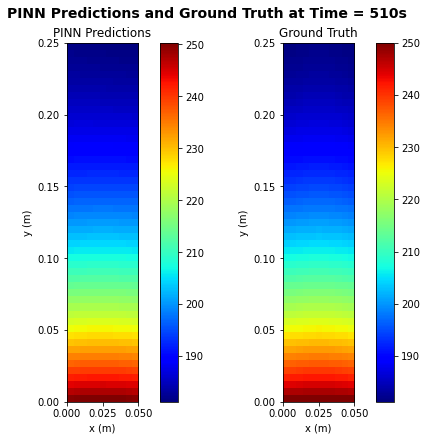

In [23]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 6), layout='constrained')

fig.suptitle('PINN Predictions and Ground Truth at Time = ' + str(eval_time) + 's',
            fontsize=14, fontweight='bold')

im0 = ax0.imshow(T, origin='lower', cmap='jet', extent=[0, 0.05, 0, 0.25])
plt.colorbar(im0, ax=ax0)
ax0.set_title('PINN Predictions')
ax0.set_xlabel('x (m)')
ax0.set_ylabel('y (m)')

#FEA Ground Truth
im1 = ax1.imshow(eval_out, origin='lower', cmap='jet', extent=[0, 0.05, 0, 0.25])
plt.colorbar(im1, ax=ax1)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')

### Contour Plot saved from training:

![Contour Plot](contours.png)